## 개발환경
python 3.8.20<br>
tensorflow 2.13
seaborn 0.13.2
matplotlib 3.7.5

In [ ]:
!pip install orbax-checkpoint==0.4.0
!pip install tensorstore==0.1.40
!pip install tf-keras==2.13.0
!pip install tensorflow==2.13.0
!pip install ml-dtypes==0.2.0

ERROR: Could not find a version that satisfies the requirement tf-keras==2.13.0 (from versions: 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1rc0, 2.15.1, 2.16.0rc0, 2.16.0rc1, 2.16.0rc2, 2.16.0rc3, 2.16.0rc4, 2.16.0, 2.17.0rc0, 2.17.0, 2.18.0rc0)
ERROR: No matching distribution found for tf-keras==2.13.0


In [1]:
pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.5.2
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.8.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.2
executing                    2.1.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

try:
    from tensorflow import keras
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import SGD
except ImportError:
    import keras
    from keras import models
    from keras import layers
    from keras.optimizers import SGD

from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=15600,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 15600)
(64,)


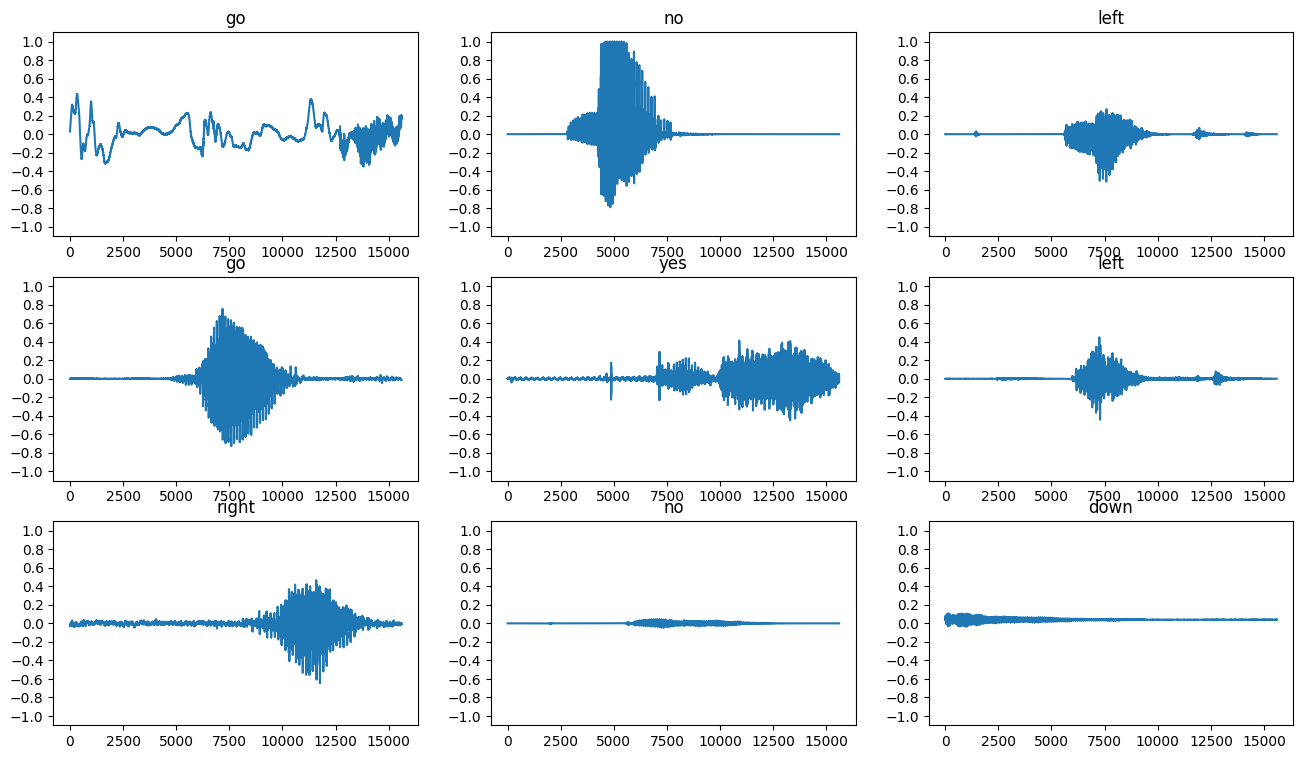

In [8]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (15600,)
Spectrogram shape: (120, 129, 1)
Audio playback


Label: no
Waveform shape: (15600,)
Spectrogram shape: (120, 129, 1)
Audio playback


Label: left
Waveform shape: (15600,)
Spectrogram shape: (120, 129, 1)
Audio playback


In [11]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

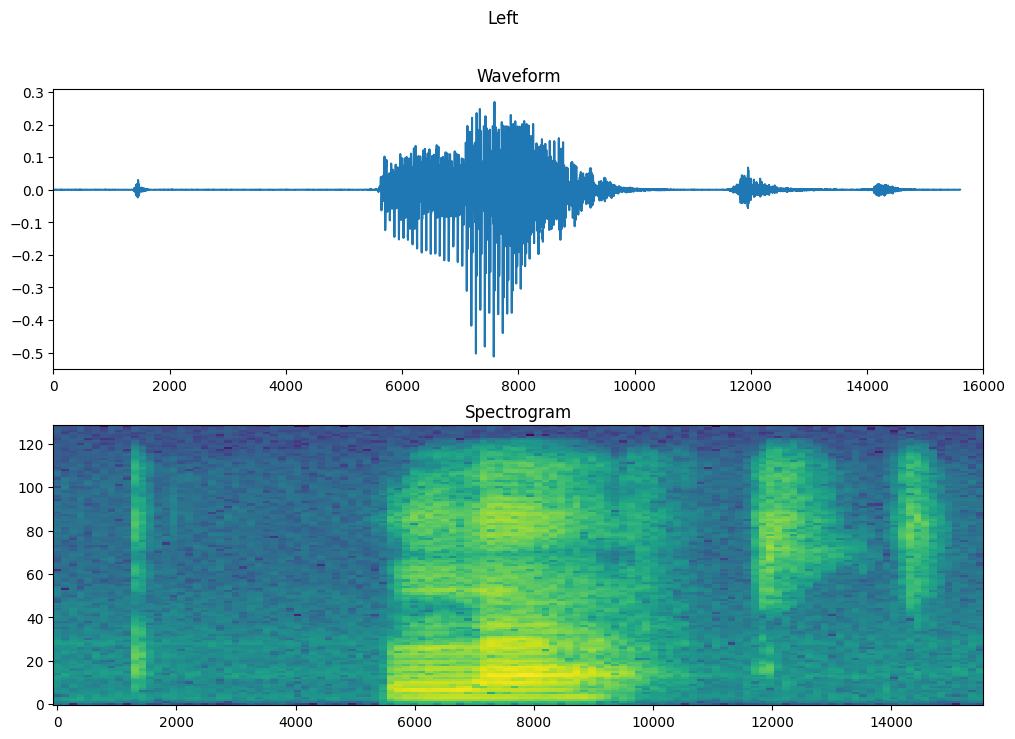

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [15]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

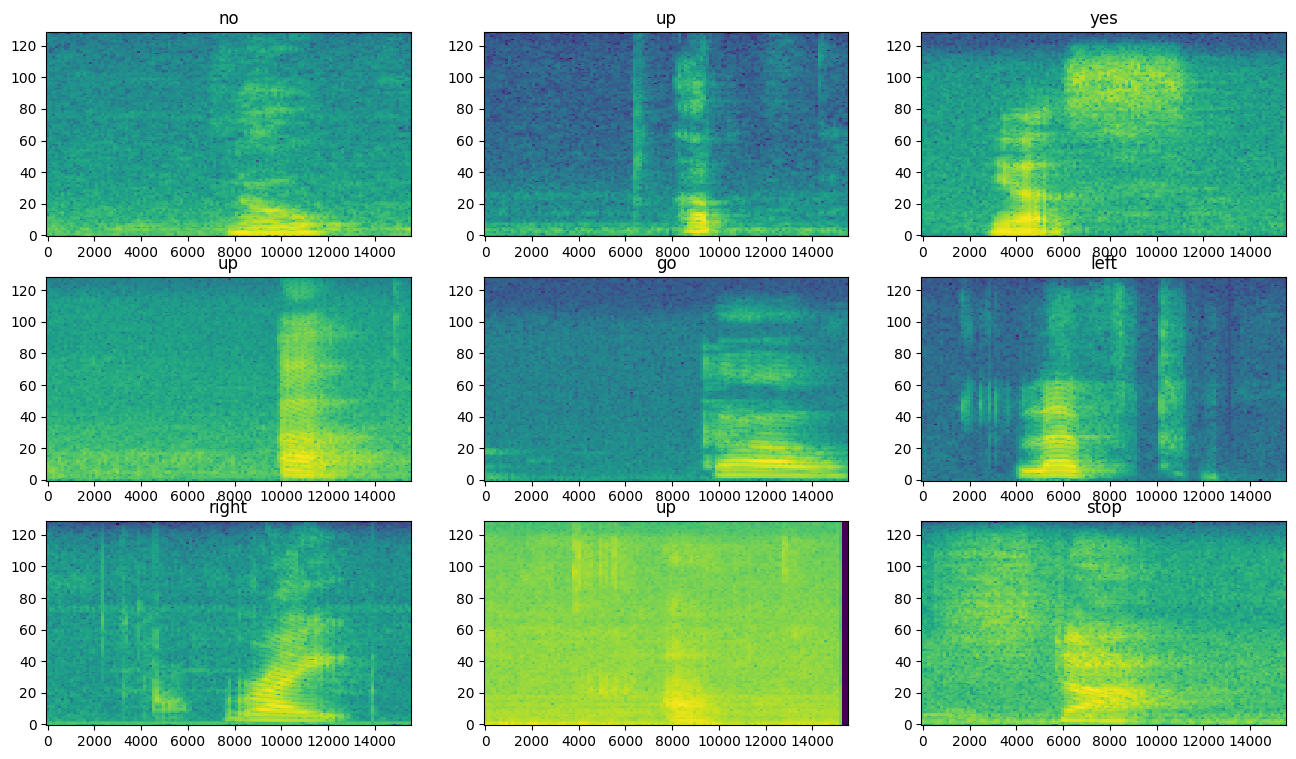

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [17]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [3]:
input_shape = (31200, ) #여기에 입력이 될 파라미터의 shape을 지정 ex) (16000, 0)
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

spectrogram_layer = layers.Lambda(get_spectrogram, name='spectrogram')

model = models.Sequential([
    layers.Input(shape=input_shape),
    spectrogram_layer,
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


model.summary()

Input shape: (31200,)


NameError: name 'commands' is not defined

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
EPOCHS = 30
history = model.fit(
    train_ds, # wav파일이 입력으로 주어짐
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
100/100 [==============================] - 10s 88ms/step - loss: 1.7495 - accuracy: 0.3678 - val_loss: 1.3170 - val_accuracy: 0.5729
Epoch 2/30
100/100 [==============================] - 9s 89ms/step - loss: 1.2029 - accuracy: 0.5703 - val_loss: 0.9769 - val_accuracy: 0.7148
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.9121 - accuracy: 0.6814 - val_loss: 0.7791 - val_accuracy: 0.7500
Epoch 4/30
100/100 [==============================] - 10s 95ms/step - loss: 0.7556 - accuracy: 0.7334 - val_loss: 0.6708 - val_accuracy: 0.7904
Epoch 5/30
100/100 [==============================] - 10s 93ms/step - loss: 0.6452 - accuracy: 0.7727 - val_loss: 0.6155 - val_accuracy: 0.8034
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.5754 - accuracy: 0.7970 - val_loss: 0.5614 - val_accuracy: 0.8216
Epoch 7/30
100/100 [==============================] - 10s 94ms/step - loss: 0.5083 - accuracy: 0.8236 - val_loss: 0.5269 - val_accuracy: 0

Text(0, 0.5, 'Accuracy [%]')

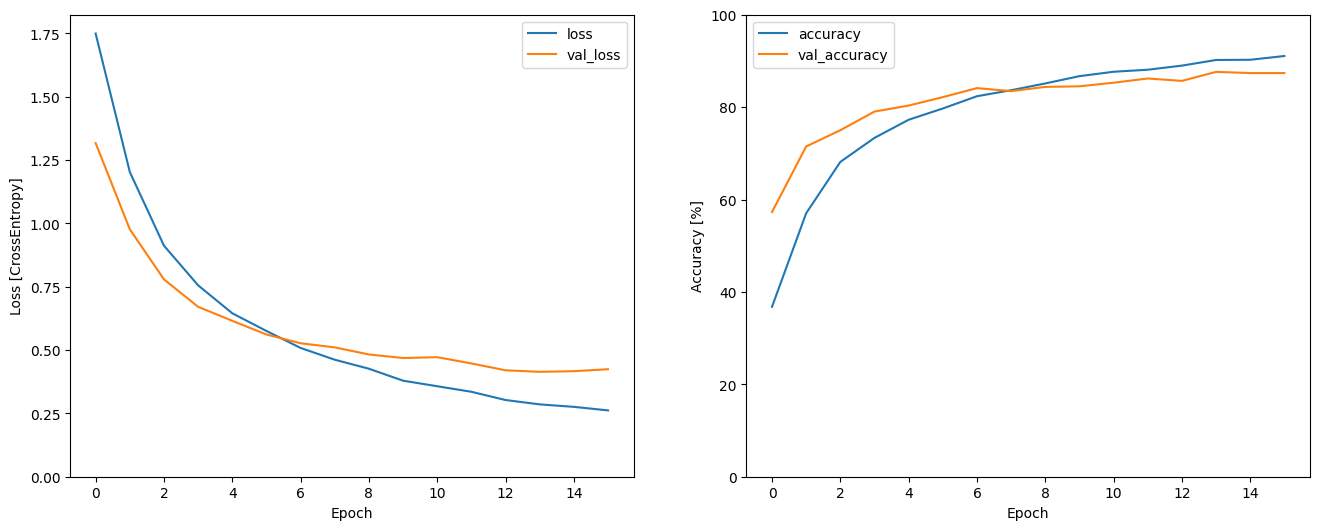

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [25]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 1s 52ms/step - loss: 0.4881 - accuracy: 0.8425


{'loss': 0.48809242248535156, 'accuracy': 0.8425480723381042}

In [26]:
y_pred = model.predict(test_ds)

13/13 [==============================] - 1s 48ms/step


In [27]:
y_pred = tf.argmax(y_pred, axis=1)

In [28]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

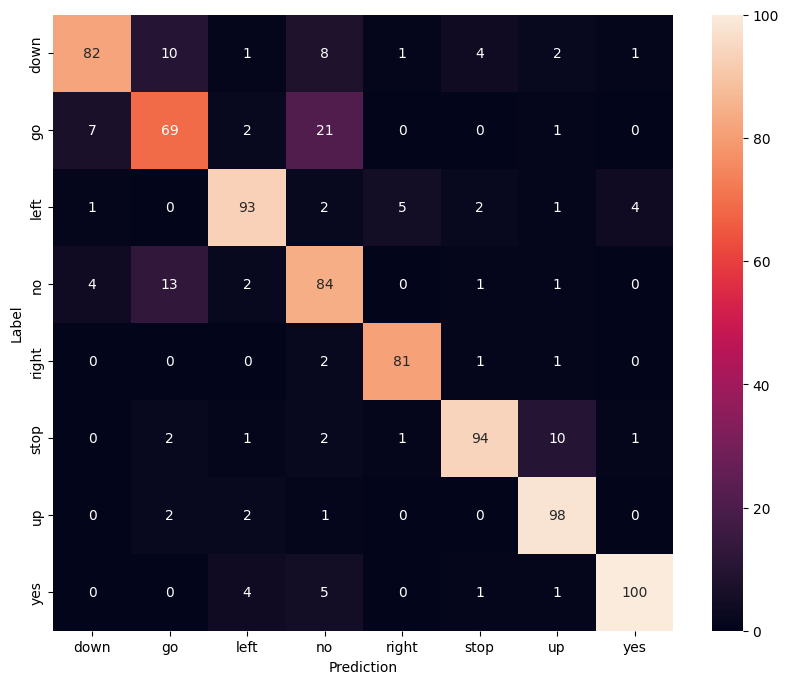

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

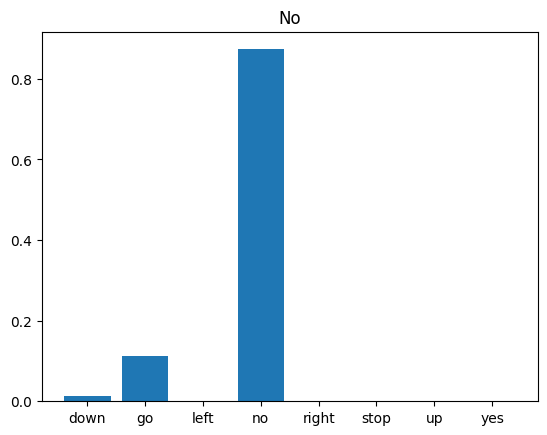

In [30]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'

# Read the audio file
audio_binary = tf.io.read_file(str(x))
waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=15600)
waveform = tf.squeeze(waveform, axis=-1)  # Remove the channel dimension

# Expand dimensions to match the model's input shape
waveform = waveform[tf.newaxis, ...]

# Make prediction by directly feeding the waveform to the model
prediction = model(waveform)

# Plot the prediction
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

# Play the audio
display.display(display.Audio(waveform[0], rate=16000))

# 끗

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram (Lambda)        (None, 120, 129, 1)       0         
                                                                 
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                 

In [32]:
model.save("saved_model_directory")

INFO:tensorflow:Assets written to: saved_model_directory\assets


INFO:tensorflow:Assets written to: saved_model_directory\assets


In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_directory")
converter.optimization = tf.lite.Optimize.DEFAULT
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.experimental_new_converter = True
converter.allow_custom_ops = True
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# tflite v2 밑에서부터는 실행안하셔도 돼요

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp699d19bn\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp699d19bn\assets


6515524

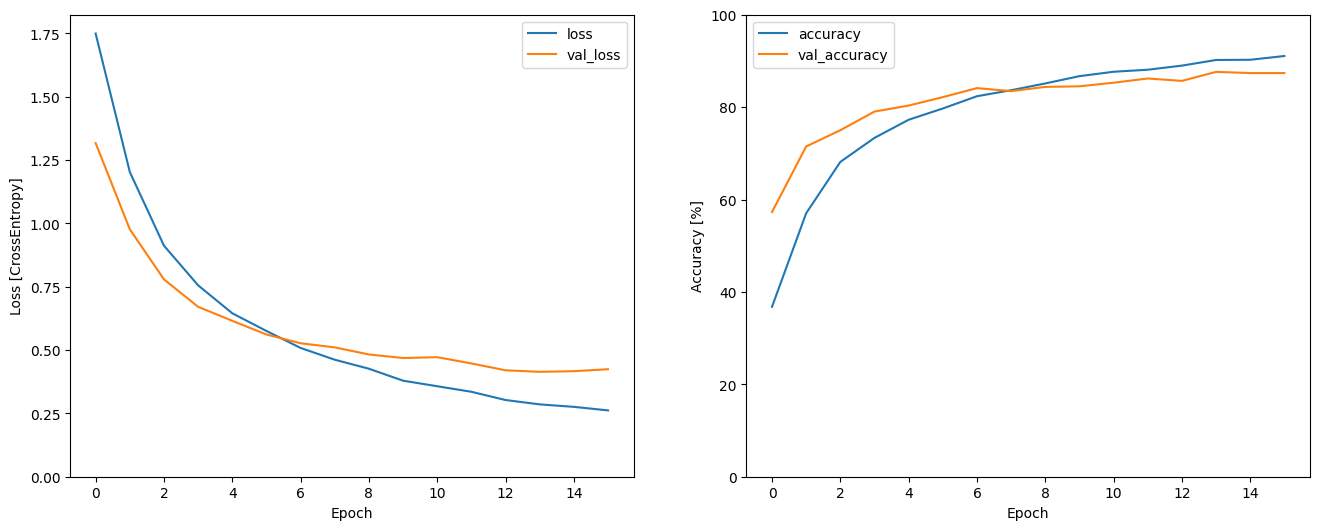

In [34]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 15600], dtype=tf.float32))

  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=15600,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

#    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(example_audio[0][tf.newaxis, :])

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS ]
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

# 끝

In [74]:
# TFLite Converter 사용
converter = tf.lite.TFLiteConverter.from_saved_model(model)

# 변환 옵션 설정 (필요할 경우, 예: 양자화)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # 기본 최적화 옵션

# 변환 수행
tflite_model = converter.convert()
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS ]
# TFLite 모델 저장
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmpojvhknzw\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmpojvhknzw\assets


ConverterError: C:\Users\SSAFY\anaconda3\envs\final\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: error: 'tf.StridedSlice' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\SSAFY\anaconda3\envs\final\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: note: Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: StridedSlice
Details:
	tf.StridedSlice(tensor<?x?x129xf32>, tensor<4xi32>, tensor<4xi32>, tensor<4xi32>) -> (tensor<?x?x129x1xf32>) : {begin_mask = 7 : i64, ellipsis_mask = 0 : i64, end_mask = 7 : i64, new_axis_mask = 8 : i64, shrink_axis_mask = 0 : i64}



In [57]:
import numpy as np
import tensorflow as tf

# TFLite 모델 로드
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# WAV 파일 로드 및 전처리 함수
def load_wav_file(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=15600)
    audio = tf.squeeze(audio, axis=-1)
    return audio.numpy()

# 예측 함수
def predict(audio_data):
    input_tensor = np.array(audio_data, dtype=np.float32)
    input_tensor = np.expand_dims(input_tensor, axis=0)
    
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# WAV 파일 경로 (예시)
wav_file_path = str(data_dir/'no/01bb6a2a_nohash_2.wav')

# WAV 파일 로드 및 전처리
audio_data = load_wav_file(wav_file_path)

# 예측 수행
prediction = predict(audio_data)

# 결과 출력
class_names = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']  # 클래스 이름 목록 (예시)
predicted_class_index = np.argmax(prediction[0])
predicted_class = class_names[predicted_class_index]
confidence = prediction[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 186: invalid start byte

In [70]:
tf.__version__

'2.13.0'